## Pytorch Lightning: Faster R-CNN

In [1]:
import os
import pandas as pd
import torch
import torch.utils.data
import torchvision
from torch.utils import data
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.faster_rcnn import RPNHead, MultiScaleRoIAlign, TwoMLPHead, FastRCNNPredictor 
from pathlib import Path, PosixPath
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar

### Check available devices (cpu or gpu)

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

There are 1 GPU(s) available.
We will use the GPU: Tesla M60


In [3]:
#clearing the occupied cuda memory
torch.cuda.empty_cache()

### Load coco annotation

In [4]:
root_dir = 'object_detection_data_1000_samples/'

In [5]:
with open(root_dir +'coco_annotation.json', 'r') as file:
     coco_annotation = json.load(file)
        
print(coco_annotation.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [6]:
coco_annotation['annotations'][5]

{'area': 245372.32013445382,
 'iscrowd': 0,
 'image_id': 0,
 'bbox': [118.12421344537815,
  746.5194444444444,
  1456.6958319327732,
  168.44444444444446],
 'category_id': 4,
 'id': 6}

### DocsDataset

In [7]:
from PIL import Image
from pycocotools.coco import COCO
import albumentations

class DocsDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation):
        self.width = 600
        self.height = 800
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys())) 

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        annotation_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(annotation_ids)
        # path for input image: 
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image (type PIL)
        img = Image.open(os.path.join(self.root, path))

    
        # number of objects(bboxes) in the image
        num_objs = len(coco_annotation)
        
        #tensor containing object categories
        category_ids = []
        for i in range(len(coco_annotation)):
            category_ids.append(coco_annotation[i]["category_id"])
        class_labels = category_ids  
            

        # Bounding boxes for objects
        # in coco format, bbox = [xmin, ymin, width, height]
        coco_boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            w = coco_annotation[i]['bbox'][2]
            h = coco_annotation[i]['bbox'][3]
            coco_boxes.append([xmin, ymin, w, h])  
            
    
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        
        # Area of the bbox
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        
        
        #resize images and bounding boxes    
        image_arr = np.array(img)
        bboxes_arr = np.array(coco_boxes)

        transformed = resize_image(image_arr, bboxes_arr, class_labels, self.height, self.width)
        #print(transformed)
        
        # in pytorch, the input bbox = [xmin, ymin, xmax, ymax]
        pytorch_boxes = []
        for bbox in transformed['bboxes']:
            bbox = list(bbox)
            xmin = bbox[0]
            ymin = bbox[1]
            w = bbox[2]
            h = bbox[3]
            xmax = xmin + w
            ymax = ymin + h
            pytorch_boxes.append([xmin, ymin, xmax, ymax])  
            
        transform = transforms.Compose ([
            transforms.ToTensor()
        ])
        
        img = transform(transformed['image'])
            
            
        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = torch.as_tensor(pytorch_boxes, dtype=torch.float32)
        my_annotation["labels"] = torch.as_tensor(transformed['class_labels'], dtype=torch.int64)
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        my_annotation
        

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [8]:
def resize_image(image_arr, bboxes, class_labels, h, w):
    transform = albumentations.Compose(
        [albumentations.Resize(height=h, width=w, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='coco', label_fields=['class_labels']))
    
    transformed = transform(image=image_arr, bboxes=bboxes, class_labels=class_labels)
    return transformed

def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
#check dataset
dataset = DocsDataset(root=root_dir, 
                      annotation = os.path.join(root_dir,'coco_annotation.json' ))

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


### Draw bounding boxes

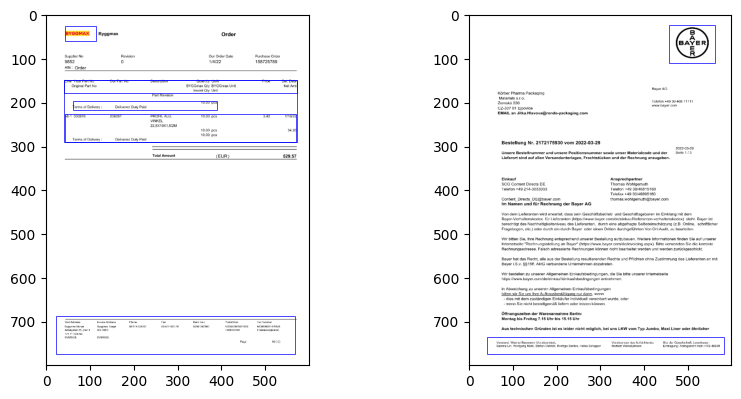

In [10]:
from matplotlib import patches

data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=2, 
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          num_workers=0)

images,labels=next(iter(data_loader)) #batch size

def draw_bboxes(images,labels,k,std=1,mean=0):
    figure = plt.figure(figsize=(10,10))
    images=list(images)
    labels=list(labels)
    
    for i in range(k):
        out=torchvision.utils.make_grid(images[i])
        inp=out.cpu().numpy().transpose((1,2,0))
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1)  
        ax = figure.add_subplot(2,2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
        l=labels[i]['boxes'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],
                                           linewidth=0.5,edgecolor='b',facecolor='none')) 

draw_bboxes(images,labels,2)

### DocsDataLoader (LightningDataModule)

In [11]:
class DocsDataLoader(pl.LightningDataModule):
    def __init__(
        self,
        root_dir: Path,
        coco_annotation_json: '',
        batch_size: int,
        stage: int = None
    ):
        super().__init__()
        self.root_dir = root_dir
        self.coco_annotation_json = coco_annotation_json
        self.batch_size = batch_size
        self.stage=stage


    def __post_init__(self):
        super().__init__()
        self.setup(self.stage)

    def setup(self, stage=None): 
        
        dataset = DocsDataset(root=self.root_dir, 
                              annotation = os.path.join(self.root_dir, self.coco_annotation_json))

        torch.manual_seed(1)
        indices = torch.randperm(len(dataset)).tolist()
        train_ind, test_ind = train_test_split(indices, test_size=0.1)
        train_ind, val_ind = train_test_split(train_ind, test_size=0.1)

        self.train_ds= torch.utils.data.Subset(dataset, train_ind)
        self.val_ds = torch.utils.data.Subset(dataset, val_ind)
        self.test_ds = torch.utils.data.Subset(dataset, test_ind)
        
        print('Training size: ', len(train_ind))
        print('Val size: ', len(val_ind))
        print('Test size: ', len(test_ind))
        

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_ds, 
                                                   batch_size=self.batch_size, 
                                                   shuffle=True,
                                                   collate_fn=collate_fn,
                                                   num_workers=2)
        return train_loader
    
    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_ds, 
                                                 batch_size=self.batch_size, 
                                                 shuffle=False,
                                                 collate_fn=collate_fn,
                                                 num_workers=2)
        return val_loader

### DocsTrainer (LightningModule)

In [12]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class DocsTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()     
        self.lr =  0.0001
        self.epochs =  1
        self.map = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        self.id2label = {0:"table", 1: "footer", 2:"header", 3:"order_line_item_header", 4:"order_line_item"}
        self.num_classes= len(self.id2label)
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=self.num_classes)
        
        
    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        #return torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        return torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)

    def training_step(self, batch, batch_idx):
        images, targets = batch 
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets) #Dict with tensors that contain loss values(cls,rpn...)
        losses = sum(loss for loss in loss_dict.values())
            
        self.log(f"train_loss", losses, prog_bar=True)
        return {"loss": losses, "outputs": {k:v.detach() for k, v in loss_dict.items()}} 


    def validation_step(self, batch, batch_idx):
        images, targets = batch 
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        #print(targets)
        
        preds = self.model(images, targets)
        #print('preds',preds)
    
        self.map.update(preds=preds, target=targets)
        return {"preds": preds[0], "targets": targets[0]}
        
        
    def training_epoch_end(self, outputs):
        final_train_loss = torch.mean(torch.stack([i["loss"] for i in outputs]))
        self.log("train_epoch_loss", final_train_loss, prog_bar=True)

        for loss_type in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
            final_loss = torch.mean(torch.stack([i["outputs"][loss_type] for i in outputs]))
            self.log(f"train_{loss_type}", final_train_loss, prog_bar=True)
        
    
  
    def validation_epoch_end(self, outputs):
        mAPs = {"val_" + k: v for k, v in self.map.compute().items()}
        self.print(mAPs)
        mAPs_per_class = mAPs.pop("val_map_per_class")
        mARs_per_class = mAPs.pop("val_mar_100_per_class")
        self.log_dict(mAPs, sync_dist=True)
        self.log_dict(
            {
                f"val_map_{label}": value
                for label, value in zip(self.id2label.values(), mAPs_per_class)
            },
            sync_dist=True,
        )
        self.log_dict(
            {
                f"val_mar_100_{label}": value
                for label, value in zip(self.id2label.values(), mARs_per_class)
            },
            sync_dist=True,
        )
        self.map.reset()
    

### Training

In [13]:
model = DocsTrainer()

data_module = DocsDataLoader(
                root_dir=root_dir, 
                coco_annotation_json='coco_annotation.json',
                batch_size=2
            )

In [14]:
trainer = pl.Trainer(callbacks=[TQDMProgressBar(refresh_rate=2)],
                     logger=pl.loggers.TensorBoardLogger("faster_rcnn_v0_logs", name="faster_rcnn_v0"))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ubuntu/.cache/pypoetry/virtualenvs/document-understanding-0ZcI-Ry7-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [15]:
trainer.fit(model, data_module)

/home/ubuntu/.cache/pypoetry/virtualenvs/document-understanding-0ZcI-Ry7-py3.9/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name  | Type                 | Params
-----------------------------------------------
0 | map   | MeanAveragePrecision | 0     
1 | model | FasterRCNN           | 41.3 M
-----------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.258   Total estimated model params size (MB)


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Training size:  795
Val size:  89
Test size:  99


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/.cache/pypoetry/virtualenvs/document-understanding-0ZcI-Ry7-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


{'val_map': tensor(0.), 'val_map_50': tensor(0.), 'val_map_75': tensor(0.), 'val_map_small': tensor(-1.), 'val_map_medium': tensor(0.), 'val_map_large': tensor(0.), 'val_mar_1': tensor(0.), 'val_mar_10': tensor(0.), 'val_mar_100': tensor(0.), 'val_mar_small': tensor(-1.), 'val_mar_medium': tensor(0.), 'val_mar_large': tensor(0.), 'val_map_per_class': tensor([0., 0., 0., 0., 0.]), 'val_mar_100_per_class': tensor([0., 0., 0., 0., 0.])}


/home/ubuntu/.cache/pypoetry/virtualenvs/document-understanding-0ZcI-Ry7-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/ubuntu/.cache/pypoetry/virtualenvs/document-understanding-0ZcI-Ry7-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
